In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
data = pd.read_csv("minute_data/BTC-USD_1M_SIGNALS.csv")
data["Variation"] = np.log(data["Close"] / data["Close"].shift(1))

In [3]:
data

,Unix,Date,Symbol,Open,High,Low,Close,Volume USD,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14
0,1483229700,2017-01-01 00:15:00,BTC/USD,965.59,966.57,965.59,966.57,-0.253468,NaN,0.749648,-0.006265,-0.005177,-0.279809,-0.226580,-8.508324e-16
1,1483229760,2017-01-01 00:16:00,BTC/USD,966.22,966.22,965.56,965.56,-0.346989,-0.001045,-1.266964,-0.007681,-0.007818,-0.278297,-0.281190,-8.508324e-16
2,1483229820,2017-01-01 00:17:00,BTC/USD,965.56,965.56,965.56,965.56,-0.348679,0.000000,-1.266964,-0.008744,-0.009013,-0.279809,-0.281190,-8.508324e-16
3,1483229880,2017-01-01 00:18:00,BTC/USD,965.56,965.56,965.55,965.55,-0.347011,-0.000010,-1.281787,-0.009543,-0.009284,-0.279305,-0.281190,-8.508324e-16
4,1483229940,2017-01-01 00:19:00,BTC/USD,965.60,965.60,965.55,965.55,-0.348361,0.000000,-1.281787,-0.010101,-0.008876,-0.279809,-0.279049,-8.508324e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675282,1646105880,2022-03-01 03:38:00,BTC/USD,43077.82,43077.82,43049.46,43049.46,-0.343970,-0.000916,-0.223879,0.326263,0.602670,1.194930,-0.281190,-6.406404e-01
2675283,1646105940,2022-03-01 03:39:00,BTC/USD,43035.16,43035.16,42999.44,42999.44,-0.174816,-0.001163,-1.000228,0.122196,-0.047445,2.240397,-0.281190,-7.082843e-01
2675284,1646106000,2022-03-01 03:40:00,BTC/USD,43022.24,43022.24,43016.03,43016.03,-0.346724,0.000386,-0.674068,0.003568,-0.345810,-0.279809,-0.281190,-8.411918e-01
2675285,1646106060,2022-03-01 03:41:00,BTC/USD,43018.23,43046.59,43018.23,43046.58,-0.318366,0.000710,-0.124560,-0.010848,-0.314059,-0.279809,1.022493,-1.022375e+00


In [4]:
data["Variation STD"] = data["Variation"].rolling(30).std()
data = data[[i%10 == 0 for i in range(len(data))]]
data = data.dropna()

In [5]:
data

,Unix,Date,Symbol,Open,High,Low,Close,Volume USD,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14,Variation STD


In [6]:
data_19_20 = data.loc[(data["Unix"] >= 1546300800) & (
        data["Unix"] < 1609459200)].reset_index(drop=True)

data_2021 = data.loc[data["Unix"] >= 1609459200].reset_index(drop=True)

display(data_19_20)

gm = GaussianMixture(2, random_state=random.randint(1,1000), init_params="k-means++")
#labels = gm.fit_predict(data_19_20.drop(["Unix", "Open", "High", "Low", "Close", "Date", "Symbol"], axis=1))
#labels = gm.fit_predict(np.array(data_19_20["Variation STD"]).reshape(-1,1))
labels = gm.fit_predict(np.array(data["Variation STD"]).reshape(-1,1))#[data_19_20.index]

,Unix,Date,Symbol,Open,High,Low,Close,Volume USD,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14,Variation STD


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 2 is required by GaussianMixture.

<AxesSubplot:>

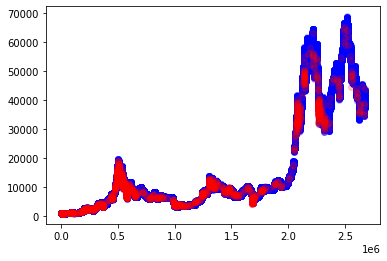

In [ ]:
data["Label"] = labels
data["Close"][labels==0].plot(style='bo', alpha=0.2)
data["Close"][labels==1].plot(style='ro', alpha=0.2)

In [ ]:
data_19_20

,Unix,Date,Symbol,Open,High,Low,Close,Volume USD,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14,Variation STD
0,1546301220,2019-01-01 00:07:00,BTC/USD,3684.59,3685.52,3684.59,3684.77,-0.333743,-0.000627,-0.568549,0.005926,-0.013892,-0.154353,-0.281190,-0.369813,0.001014
1,1546301820,2019-01-01 00:17:00,BTC/USD,3687.96,3687.96,3687.96,3687.96,-0.348679,0.000000,-0.339166,0.022283,-0.020790,-0.279809,-0.281190,-0.494274,0.000532
2,1546302420,2019-01-01 00:27:00,BTC/USD,3688.35,3688.35,3688.35,3688.35,-0.348679,0.000000,-0.171752,-0.015758,-0.040523,-0.279809,-0.281190,-0.636182,0.000679
3,1546303020,2019-01-01 00:37:00,BTC/USD,3696.87,3696.87,3696.87,3696.87,-0.348679,0.000000,1.226181,0.060030,0.094531,-0.279809,-0.281190,-0.243854,0.000605
4,1546303620,2019-01-01 00:47:00,BTC/USD,3696.35,3696.35,3696.35,3696.35,-0.348679,0.000000,0.716425,0.051668,-0.013807,-0.279809,-0.281190,-0.541656,0.000158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101327,1609456500,2020-12-31 23:15:00,BTC/USD,29134.43,29143.60,29109.75,29125.00,1.859660,-0.000324,0.195748,-0.076341,0.693356,-0.279809,0.033621,0.296691,0.000639
101328,1609457100,2020-12-31 23:25:00,BTC/USD,29071.43,29090.15,29049.87,29049.87,1.707871,-0.000742,-1.103177,-0.374352,-0.721894,0.437659,-0.281190,-0.097455,0.001015
101329,1609457700,2020-12-31 23:35:00,BTC/USD,29021.32,29038.45,29021.32,29025.14,-0.174121,-0.000452,-0.761954,-0.735089,-0.206768,-0.279809,-0.281190,0.924215,0.000812
101330,1609458300,2020-12-31 23:45:00,BTC/USD,28887.99,28898.45,28843.74,28898.45,2.616730,-0.000212,-1.891504,-1.058544,-1.120155,1.463980,-0.281190,1.105225,0.001385


<AxesSubplot:>

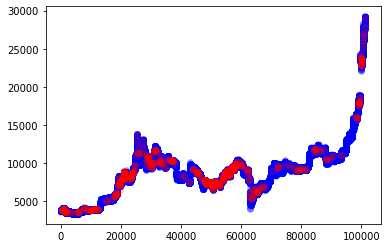

In [ ]:
labels = labels[data_19_20.index]
data_19_20["Label"] = labels
data_19_20["Close"][labels==0].plot(style='bo', alpha=0.2)
data_19_20["Close"][labels==1].plot(style='ro', alpha=0.2)

In [ ]:
pd.Series(labels).value_counts()

0    100253
1      1079
dtype: int64

<AxesSubplot:>

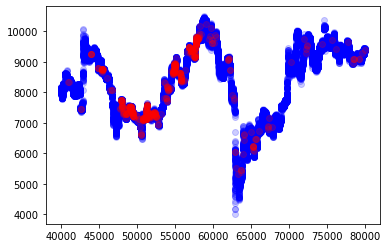

In [ ]:
data_split = data_19_20[40000:80000]
data_split["Close"][data_split["Label"]==0].plot(style='bo', alpha=0.2)
data_split["Close"][data_split["Label"]==1].plot(style='ro', alpha=0.2)

In [ ]:
print(gm.means_)
print()
print(gm.covariances_)
print()
print(gm.weights_)

[[0.00096081]
 [0.00399217]]

[[[1.54281904e-06]]

 [[1.36870942e-05]]]

[0.9832544 0.0167456]
